In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time 

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pinocchio as pin
from scipy.optimize import least_squares
from scipy.special import huber
from projectyl.utils.properties import ELBOW, SHOULDER, WRIST
from projectyl.dynamics.armmodel import ArmRobot
from projectyl.dynamics.meshcat_viewer_wrapper import MeshcatVisualizer

In [3]:
arm_robot = ArmRobot(upper_arm_length=0.3, forearm_length=0.25)

In [4]:
viz = MeshcatVisualizer(arm_robot)
arm_robot.model.createData()
viz.display(arm_robot.q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


TESTS arm moving, random constant acceleration

In [5]:
q = arm_robot.q0.copy()
vq = np.zeros(arm_robot.model.nv)
aq = 5 * np.random.rand(arm_robot.model.nv)
viz.display(q)
DT = 1e-2

T = 30

rec_gt_sol = []
rec_gt_p = []

shoulder_joint_id = arm_robot.model.getJointId(SHOULDER)
elbow_joint_id = arm_robot.model.getJointId(ELBOW)
end_effector_frame_id = arm_robot.model.getFrameId(WRIST)

In [6]:
for _ in range(T):
    # Iterative forward dynamics
    vq += aq * DT
    q = pin.integrate(arm_robot.model, q, vq * DT)
    tauq = pin.rnea(arm_robot.model, arm_robot.data, q, vq, aq)
    
    # Retrieve 3D points (forward kinematics)
    pin.framesForwardKinematics(arm_robot.model, arm_robot.data, q)
    shoulder_p = arm_robot.data.oMi[shoulder_joint_id].translation
    elbow_p = arm_robot.data.oMi[elbow_joint_id].translation
    end_effector_p = arm_robot.data.oMf[end_effector_frame_id].translation

    viz.display(q)
    # Store ground truth "solutions" (q, vq, tau)
    xuc = np.concatenate([q, vq, tauq])
    rec_gt_sol.append(xuc)
    # Store ground truth data (p)
    p = np.concatenate([shoulder_p, elbow_p, end_effector_p])
    rec_gt_p.append(p)
    time.sleep(1e-2)

In [7]:
q.shape # 4 +1 DOF elbow
vq.shape # 4 =  3(axis angle 3D ~  log map of quaternion 4D ) + 1 DOF elbow
tauq.shape # 4 = 3 + 1 
xuc.shape # 5 + 4 + 4 = 13  = position + velocity + torque

(13,)

In [8]:
gt_sol = np.vstack(rec_gt_sol)
gt_p = np.vstack(rec_gt_p)
gt_sol.shape, gt_p.shape # T=180 step, 13 "xuc" and 9 3D positions
# sol = solution...
# p = position = oberserved data...

((30, 13), (30, 9))

# Cost terms definitions

In [9]:
def get_pose_velocity_from_state(tq_normalized, tvq, T):
    # Forward pass
    rec_p = []
    rec_v = []

    for t in range(T):
        q = tq_normalized[t]
        vq = tvq[t]
        # (forward kinematics)
        pin.forwardKinematics(arm_robot.model, arm_robot.data, q, vq)
        pin.updateFramePlacements(arm_robot.model, arm_robot.data)
        # Predicted 3D points -> 3x3 points
        shoulder_p = arm_robot.data.oMi[shoulder_joint_id].translation
        elbow_p = arm_robot.data.oMi[elbow_joint_id].translation
        end_effector_p = arm_robot.data.oMf[end_effector_frame_id].translation
        # Predicted 3D velocities -> ingnore shoulder 2x3 points
        shoulder_lv = arm_robot.data.v[shoulder_joint_id]
        elbow_lv = arm_robot.data.v[elbow_joint_id]
        # 
        shoulder_v = arm_robot.data.oMi[shoulder_joint_id].act(shoulder_lv).linear
        elbow_v = arm_robot.data.oMi[elbow_joint_id].act(elbow_lv).linear
        end_effector_v = pin.getFrameVelocity(arm_robot.model, arm_robot.data, end_effector_frame_id, pin.ReferenceFrame.WORLD).linear

        p = np.concatenate([shoulder_p, elbow_p, end_effector_p])
        rec_p.append(p)

        v = np.concatenate([shoulder_v, elbow_v, end_effector_v])
        rec_v.append(v)

    tp = np.vstack(rec_p)
    tv = np.vstack(rec_v)

    ta = (tv[1:] - tv[:-1]) / DT

    return tp, tv, ta

In [10]:
def diff_3D(tp, tp_observed):
    diff = tp - tp_observed
    diff = diff.flatten()

    return diff

In [11]:
def smooth_velocity_acceleration(tv, ta):

    rv = tv.flatten()
    ra = ta.flatten()

    return np.concatenate([rv, ra])

In [12]:
def smooth_torque(ttauq):
    return ttauq.flatten()

In [13]:
# If the Lagrange dynamics formulation cannote be totally satisfied,
# one can relax by minimizing the difference between:
# - the Lagrange dynamics torques tau_rec predicited from q, vq and aq.
# - the current predicted torques ttauq
# question: why not also going backward in time ?
def full_body_dynamics(tq_normalized, tvq, taq, ttauq, T):
    
    tau_rec = []

    for t in range(1, T):
        tau = pin.rnea(arm_robot.model, arm_robot.data, tq_normalized[t], tvq[t], taq[t - 1])
        # taq[t - 1] ?

        tau_rec.append(tau)
    
    ttau = np.vstack(tau_rec)

    diff = ttau - ttauq[1:]
    # ttauq[1:] - cannot compute ttau for t=0
    
    diff = diff.flatten()

    return diff

In [14]:
# Build the cost function
def objective(txuc, tp_observed, T, debug=False) -> np.ndarray:
    txuc_r = txuc.reshape(T, -1)

    tq = txuc_r[:, :arm_robot.model.nq]
    norm_quat = np.linalg.norm(tq[:, :-1], axis=1, keepdims=True)
    tq_normalized = tq.copy()
    tq_normalized[:, :-1] /= norm_quat

    tvq = txuc_r[:, arm_robot.model.nq: arm_robot.model.nq + arm_robot.model.nv]

    taq = (tvq[1:] - tvq[:-1]) / DT

    ttauq = txuc_r[:, arm_robot.model.nq + arm_robot.model.nv:]

    tp, tv, ta = get_pose_velocity_from_state(tq_normalized, tvq, T)

    # DEBUG
    if debug:
        print("3D joint positions", np.linalg.norm(diff_3D(tp, tp_observed)))
        print("Smooth velocity acceleration", np.linalg.norm(smooth_velocity_acceleration(tv, ta)))
        print("Smooth torque", np.linalg.norm(smooth_torque(ttauq)))
        print("Full body dynamics", np.linalg.norm(full_body_dynamics(tq_normalized, tvq, taq, ttauq, T)))

    res = np.concatenate([
        diff_3D(tp, tp_observed),
        0.1 * smooth_velocity_acceleration(tv, ta),
        0.1 * smooth_torque(ttauq),
        10 * full_body_dynamics(tq_normalized, tvq, taq, ttauq, T),
    ])

    return res

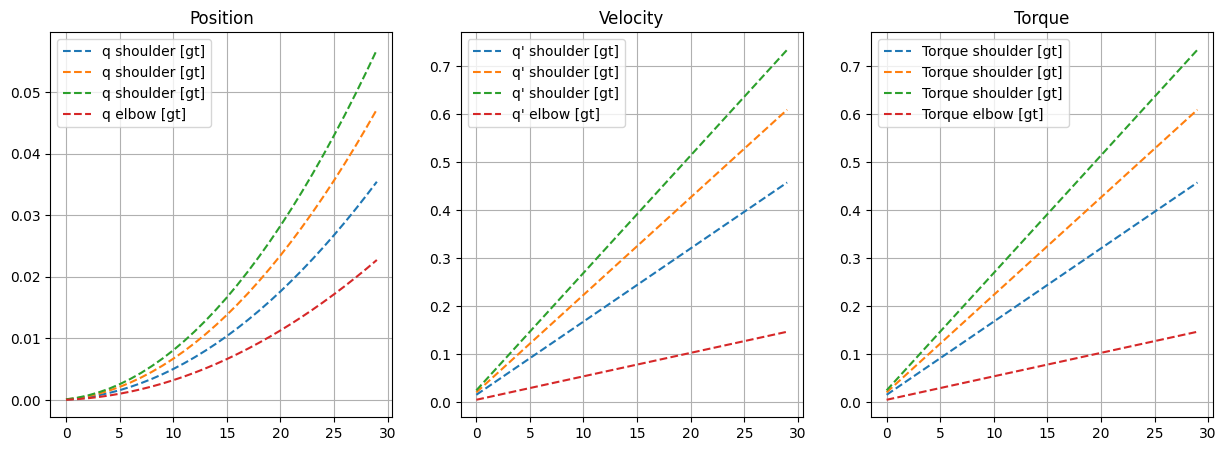

In [26]:
import matplotlib.pyplot as plt
state = gt_sol
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for state, label, style in [(gt_sol, "[gt]", "--"),]:
    axs[0].plot(state[:, :3], style, label=f"q shoulder {label}") # skip index 3 (quaternion normalization)
    axs[0].plot(state[:, 4], style, label=f"q elbow {label}")
    axs[0].set_title("Position")
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(state[:, 4+1:4+3+1], style, label=f"q' shoulder {label}")
    axs[1].plot(state[:, 4+3+1], style, label=f"q' elbow {label}")
    axs[1].legend()
    axs[1].grid()
    axs[1].set_title("Velocity")

    axs[2].plot(state[:, 4+1:4+3+1], style, label=f"Torque shoulder {label}")
    axs[2].plot(state[:, 4+3+1], style, label=f"Torque elbow {label}")
    axs[2].set_title("Torque")
    axs[2].legend()
    axs[2].grid()

plt.show()

In [29]:
# intialized with ground truth data for angular positions
# and 0 for velocity
# and 0 for torques
q = gt_sol[:, :arm_robot.model.nq]

initial = np.concatenate([q, np.zeros((T, 2 * arm_robot.model.nv))], axis=1)

In [ ]:
sol = least_squares(objective, initial.flatten(), args=(gt_p, T)).x

In [ ]:
print(np.linalg.norm(gt_sol.flatten()- sol.flatten()))

In [ ]:
res = sol.reshape(T, -1)

In [ ]:
np.linalg.norm(objective(sol, gt_p, T, True))

In [ ]:
np.linalg.norm(objective(gt_sol.flatten(), gt_p, T, True))

In [ ]:
tq = res[:, :arm_robot.model.nq]
print(tq.shape)
norm_quat = np.linalg.norm(tq[:, :-1], axis=1, keepdims=True)
tq_normalized = tq.copy()
tq_normalized[:, :-1] /= norm_quat

tvq = res[:, arm_robot.model.nq: arm_robot.model.nq + arm_robot.model.nv]


ttauq = res[:, arm_robot.model.nq + arm_robot.model.nv:]

In [ ]:
for t in range(T):

    viz.display(tq_normalized[t])

    time.sleep(1e-2)

In [ ]:
for t in range(T):
    viz.display(gt_sol[t, :arm_robot.model.nq])
    time.sleep(1e-2)